Purely a placeholder notebook for now. I'll need to adapt my own scripts and combine with whatever the current grizli functions are doing.

In [1]:
import os
from pathlib import Path

# This is currently a necessity; newer pipeline reductions do not work with grizli
os.environ["CRDS_CONTEXT"] = "jwst_1173.pmap"

root_dir = Path(os.getenv("ROOT_DIR"))

In [2]:
import shutil, logging
from astropy.io import fits
import grizli
from grizli import utils, prep, jwst_utils, multifit
from grizli.pipeline import auto_script

print("Grizli version: ", grizli.__version__)

# Quiet JWST log warnings
jwst_utils.QUIET_LEVEL = logging.INFO
jwst_utils.set_quiet_logging(jwst_utils.QUIET_LEVEL)

root_name = "glass-a2744"

# Set up the grizli directory structure
grizli_home_dir = root_dir / "2024_08_16_A2744_v4" / "grizli_home"

os.chdir(grizli_home_dir / "Prep")
os.chdir(grizli_home_dir / "tests" / "Prep_tests")

Grizli version:  0.1.dev3239+gbcce2c0.d20241014


In [6]:
os.chdir(grizli_home_dir / "tests" / "Prep_tests")

from grizli import prep

seg_cat_name = f"{root_name}-ir.cat.fits"

multiband_catalog_args = auto_script.get_yml_parameters()["multiband_catalog_args"]
# multiband_catalog_args["detection_params"]["filter_type"] = "matched"
# multiband_catalog_args["detection_params"]["deblend_nthresh"] = 128
# multiband_catalog_args["detection_params"]["deblend_cont"] = 1e-4
# # multiband_catalog_args["detection_background"] = False
# multiband_catalog_args["bkg_params"] = {
#     "bw" : 256,
#     "bh" : 256,
#     "fw" : 5,
#     "fh" : 5,
#     "pixel_scale" : 0.06
# }
# # print (multiband_catalog_args)
# # if not (Path.cwd() / seg_cat_name).is_file():

phot_cat = auto_script.multiband_catalog(
    field_root=root_name,
    **multiband_catalog_args
)

# (2024-10-14 11:39:26.745)

auto_script.multiband_catalog(**{'field_root': 'glass-a2744', 'threshold': 1.0, 'detection_background': True, 'photometry_background': True, 'get_all_filters': False, 'filters': None, 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': False, 'run_detection': True, 'detection_filter': 'ir', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 32, 'deblend_

2024-10-14 13:39:27,039 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/grizli/prep.py:1976: RuntimeWarning: divide by zero encountered in divide
  err_data = 1/np.sqrt(wht_data)



# (2024-10-14 11:39:27.127)
SEP: Get background {'bw': 128.00000000000028, 'bh': 128.00000000000028, 'fw': 3, 'fh': 3}


KeyboardInterrupt: 

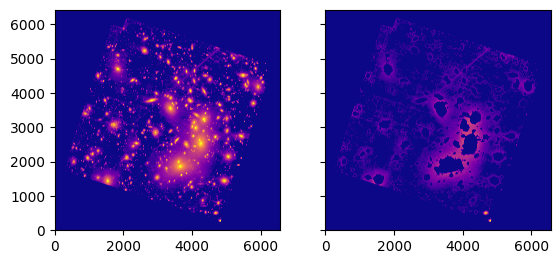

In [4]:
import numpy as np
from astropy.table import Table, join
from astropy.coordinates import SkyCoord, match_coordinates_sky
import matplotlib.pyplot as plt
import astropy.visualization as astrovis

plot = True

bcg_cat = Table.read("v4_bcg_cat.fits")
bcg_cat.sort("FLUX_AUTO", reverse=True)

curr_cat = Table.read(f"{root_name}-ir.cat.fits")

# bcg_coords = SkyCoord(ra=bcg_cat["RA"], dec=bcg_cat["DEC"])
# curr_coords = SkyCoord(ra=curr_cat["RA"], dec=curr_cat["DEC"])
prev_seg_path = "prev_seg_map.fits"
prev_seg_map = fits.getdata(prev_seg_path).astype(int)
bcg_seg_map = prev_seg_map.copy()
bcg_seg_map[~np.isin(bcg_seg_map, bcg_cat["NUMBER"])] = 0
detect_img = fits.getdata(f"{root_name}-ir_drc_sci.fits")

if plot:

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    plot_kwargs = {
        "norm": astrovis.ImageNormalize(
            detect_img,
            # interval=astrovis.PercentileInterval(99.5),
            interval=astrovis.ManualInterval(0,5),
            stretch=astrovis.LogStretch(),
        ),
        "origin": "lower",
        "cmap" : "plasma",
    }
    axs[0].imshow(
        detect_img,
        **plot_kwargs,
    )
    axs[1].imshow(
        detect_img * (1 - (prev_seg_map > 0)),
        **plot_kwargs,
    )
    # axs[1].imshow(
    #     detect_img * (bcg_seg_map > 0),
    #     **plot_kwargs,
    # )

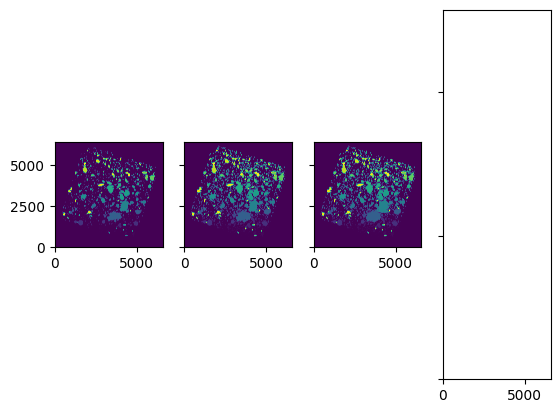

In [5]:
from skimage.segmentation import expand_labels
from astropy.convolution import convolve_fft, Gaussian2DKernel

conv_detect = convolve_fft(detect_img, Gaussian2DKernel(3, 3))

# masked_seg_map = new_seg_map.copy()

# masked_seg_map[(~np.isin(masked_seg_map, bcg_cat["NUMBER"]) & (masked_seg_map>0)) | (conv_detect<0)] = 1e9
# axs[2].imshow(masked_seg_map)

# expand_bcgs = expand_labels(bcg_seg_map, distance=250)

# new_seg_map = prev_seg_map.copy()
threshold = 0.005

expand_all = expand_labels(prev_seg_map, distance=10)

new_seg_map = prev_seg_map.copy()
new_seg_map[(new_seg_map == 0) & (conv_detect >= 0)] = expand_all[
    (new_seg_map == 0) & (conv_detect >= 0)
]

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
axs[0].imshow(prev_seg_map, origin="lower")
axs[1].imshow(new_seg_map, origin="lower")

# from astropy.convolution import convolve_fft, Gaussian2DKernel

# conv_detect = convolve_fft(detect_img, Gaussian2DKernel(3,3))

# masked_seg_map = new_seg_map.copy()

# masked_seg_map[(~np.isin(masked_seg_map, bcg_cat["NUMBER"]) & (masked_seg_map>0)) | (conv_detect<0)] = 1e9
# axs[2].imshow(masked_seg_map)

# expand_bcgs = expand_labels(bcg_seg_map, distance=250)

# new_seg_map = prev_seg_map.copy()
threshold = 0.005
# new_seg_map[(new_seg_map==0) & (conv_detect>=threshold)] = expand_bcgs[(new_seg_map==0) & (conv_detect>=threshold)]
# new_seg_map[(new_seg_map==0) & (detect_img>=0)] = expand_bcgs[(new_seg_map==0) & (detect_img>=0)]

# axs[3].imshow(new_seg_map, origin="lower")

# # groups = []
central_bcg_map = new_seg_map.copy()
central_bcg_map[~np.isin(central_bcg_map, bcg_cat["NUMBER"][:2])] = 0
new_seg_map[(new_seg_map == 0) & (conv_detect >= threshold)] = expand_labels(
    central_bcg_map, distance=100
)[(new_seg_map == 0) & (conv_detect >= threshold)]

# # # axs[2].imshow(central_bcg_map, origin="lower")
axs[2].imshow(new_seg_map, origin="lower")

iter_bcg_map = new_seg_map.copy()
iter_bcg_map[~np.isin(iter_bcg_map, bcg_cat["NUMBER"][:12])] = 0
new_seg_map[new_seg_map==0] = expand_labels(iter_bcg_map, distance=50)[new_seg_map==0]

iter_bcg_map = new_seg_map.copy()
iter_bcg_map[~np.isin(iter_bcg_map, bcg_cat["NUMBER"][:])] = 0
new_seg_map[new_seg_map==0] = expand_labels(iter_bcg_map, distance=25)[new_seg_map==0]


central_bcg_map = new_seg_map.copy()
central_bcg_map[~np.isin(central_bcg_map, bcg_cat["NUMBER"][:2])] = 0
new_seg_map[(new_seg_map == 0) & (conv_detect >= threshold)] = expand_labels(
    central_bcg_map, distance=100
)[(new_seg_map == 0) & (conv_detect >= threshold)]

iter_bcg_map = new_seg_map.copy()
iter_bcg_map[~np.isin(iter_bcg_map, bcg_cat["NUMBER"][:12])] = 0
new_seg_map[new_seg_map==0] = expand_labels(iter_bcg_map, distance=50)[new_seg_map==0]

# # # axs[2].imshow(central_bcg_map, origin="lower")
# # axs[3].imshow(new_seg_map, origin="lower")

# # # expand_all_seg = expand_labels(curr_seg_map, distance=5)
# # # test_img = expand_all_seg.copy()
# # # # test_img[~np.isin(test_img, obj_ids)] = 0.
# # # expanded_map = curr_seg_map.copy()
# # # expanded_map[~np.isin(expanded_map, obj_ids)] = 0
# # expanded_map = expand_labels(bcg_seg_map, distance=150)
# # prev_seg_map[prev_seg_map == 0] = expanded_map[prev_seg_map == 0]
# # plt.imshow(prev_seg_map, origin="lower")

# print (len(np.unique(prev_seg_map)))
# use_regen_seg = new_seg_map.astype(np.int32)
# # # expanded_image = expand_labels(test_img, distance=150)
# # # new_seg = expand_all_seg.copy()
# # # new_seg[new_seg==0] = expanded_image[new_seg==0]
# # # fig, axs = plt.subplots(1,2)
# # # axs[0].imshow(repr_seg_map2, origin="lower")
# # # # axs[1].imshow(expand_all_seg, origin="lower")
# # # axs[1].imshow(new_seg, origin="lower")

# # # print (np.unique(expanded_image))
new_seg_hdul = fits.HDUList(
    hdus=[
        fits.PrimaryHDU(data=new_seg_map.copy(), header=fits.getheader(prev_seg_path)),
    ]
)
new_seg_hdul.writeto("new_seg_map.fits", overwrite=True)

# # # # prep.make_SEP_catalog(
# # # #     root=f"{root_name}-ir",
# # # #     threshold=1.0,
# # # #     bkg_params={"bw": 64, "bh": 64, "fw": 3, "fh": 3, "pixel_scale": 0.06},
# # # #     source_xy=(
# # # #         prev_tab["X_WORLD"],
# # # #         prev_tab["Y_WORLD"],
# # # #         expanded_seg,
# # # #         prev_tab["NUMBER"].astype(np.int32),
# # # #     ),
# # # #     save_to_fits=False,
# # # #     rescale_weight=False,
# # # # )

# # # print (len(prev_tab))
# # print(len(np.unique(use_regen_seg)))

# # import shutil

# # shutil.copy2(f"{root_name}-ir.cat.fits", f"old__{root_name}-ir.cat.fits")
# # shutil.copy2(f"{root_name}-ir_seg.fits", f"old__{root_name}-ir_seg.fits")

In [13]:

from glass_niriss.pipeline import regen_catalogue

use_regen_seg = np.asarray(segment_map).astype(np.int32)
new_cat = regen_catalogue(
    use_regen_seg,
    root=f"{root_name}-ir",
    # suffix="_new"
)

2024-10-11 18:43:22,294 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/misc.py:475: RuntimeWarning: divide by zero encountered in divide
  err_data = 1 / np.sqrt(wht_data)



make_SEP_catalog: sep version = 1.3.6
# (2024-10-11 16:43:22.192)
make_SEP_catalog: glass-a2744-ir_drc_sci.fits weight=glass-a2744-ir_drc_wht.fits (MAP_WEIGHT)
make_SEP_catalog: Image AB zeropoint =  28.900
# (2024-10-11 16:43:22.377)
SEP: Get background {'bw': 128.00000000000028, 'bh': 128.00000000000028, 'fw': 3, 'fh': 3}


2024-10-11 18:43:23,198 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/misc.py:554: RuntimeWarning: divide by zero encountered in divide
  ratio = bkg.rms() / err_data



   SEP: Extract...
label     xcentroid      ...     kron_flux          kron_fluxerr   
                         ...                                       
----- ------------------ ... ------------------ -------------------
    1  4812.465305606921 ...  4124.127187101427  2.6458372203801064
    2  4826.628431189035 ...  8.632581363927464 0.44261363593080233
    3  4801.119394665517 ...  40.40210192330176   0.434444637082685
    4  4658.967093373607 ...  3.917291045464285 0.18784473214566963
    5  4677.733970339894 ...  5.415693802577396 0.18920297704037187
    6  4409.742534462466 ... 2.8124962357911283 0.15626761173914488
    7  4380.222569865964 ...   818.014000961983  0.7912193006990295
    8  4224.400648063764 ... 2.1992382950791454 0.15766613428093837
    9  4527.645603151995 ... 25.671562798039027 0.31410450135816886
  ...                ... ...                ...                 ...
 2740 2535.0380621936088 ... 13.711204402930598  0.3705348049634491
 2741 2581.0580397318545 ... 

2024-10-11 18:43:28,178 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/pipeline/misc.py:763: RuntimeWarning: invalid value encountered in log10
  tab["mag_iso"] = 23.9 - 2.5 * np.log10(tab["flux_iso"])



compute_SEP_auto_params: sep version = 1.2.1
compute_SEP_auto_params: autoparams=[2.5, <Quantity 0.35 arcsec>, 2.4, 3.8]; pixel_scale=0.029999999999999933; subpix=0; flux_radii=[0.2, 0.5, 0.9]


Exception: invalid aperture parameters

2024-10-11 19:02:23,468 - stpipe - WARNING - /tmp/ipykernel_43272/19489974.py:4: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt(1/detect_wht)



Deblending:   0%|          | 0/2201 [00:00<?, ?it/s]

2024-10-11 19:08:12,593 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/photutils/segmentation/deblend.py:232: AstropyUserWarning: The deblending mode of one or more source labels from the input segmentation image was changed from "exponential" to "linear". See the "info" attribute for the list of affected input labels.
  warnings.warn('The deblending mode of one or more source labels from '



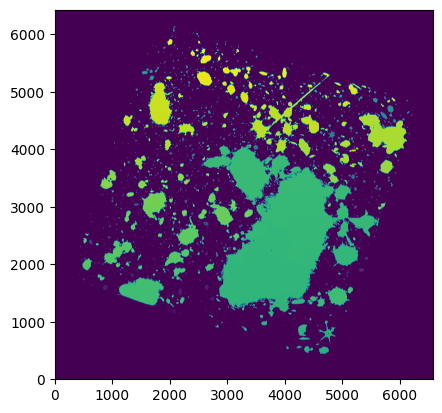

In [16]:
detect_img = fits.getdata(f"{root_name}-ir_drc_sci.fits")
detect_wht = fits.getdata(f"{root_name}-ir_drc_wht.fits")

err = np.sqrt(1/detect_wht)

from photutils.segmentation import SegmentationImage, SourceCatalog, SourceFinder

finder = SourceFinder(
    npixels=9,
    nlevels=64,
    contrast=1e-3,
    nproc=8
)
segment_map = finder(conv_detect, threshold = 1.*err)

plt.imshow(segment_map, origin="lower")


new_seg_hdul = fits.HDUList(
    hdus=[
        fits.PrimaryHDU(data=segment_map.copy(), header=fits.getheader(prev_seg_path)),
    ]
)
new_seg_hdul.writeto("photutils_seg_map.fits", overwrite=True)
# new_seg = fits.getdata(f"{root_name}-ir_seg_new.fits")
# new_seg_cat = fits.getdata(f"{root_name}-ir.cat_new.fits")
# test_seg = use_regen_seg - new_seg

# print (np.unique(test_seg))
# print (len(np.unique(test_seg)))

# missing_data = curr_cat[~np.isin(curr_cat["NUMBER"], new_cat["number"])]

# missing_data["NUMBER"]
# print (missing_data["NUMBER"])

# plot_seg = use_regen_seg.copy()
# plot_seg[~np.isin(plot_seg,missing_data["NUMBER"])] = 0
# plot_seg[plot_seg>0] = 1.
# import matplotlib.pyplot as plt
# plt.imshow(plot_seg, origin="lower")

In [7]:
# out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss"
# conv_out_dir = out_base_dir / "PSF_matched_data"
# repr_seg_path = conv_out_dir / "repr_seg_map_2.fits"

# from astropy.table import Table
# import matplotlib.pyplot as plt
# import numpy as np

# init_table = Table.read(root_dir / "2023_11_27__data_products_for_reduction" / "ancillary" / "matched_cat.fits")
# phot_cat = Table.read(root_dir / "2023_11_07_spectral_orders" / "Prep" / "nis-wfss-ir.cat.fits")
# repr_seg_path = root_dir / "2023_11_07_spectral_orders" / "Prep" / "nis-wfss-ir_seg.fits"

# phot_cat = phot_cat[np.isin(phot_cat["NUMBER"],init_table["id"])]
# print (len(phot_cat))
# phot_cat.sort("FLUX", reverse=True)
# obj_ids = np.asarray(phot_cat["NUMBER"])
# obj_ids = [1289,1898]

# with fits.open(repr_seg_path) as repr_seg_hdul:
#     repr_seg_map2 = repr_seg_hdul[0].data

# from skimage.segmentation import expand_labels

# expand_all_seg = expand_labels(repr_seg_map2, distance=5)
# test_img = expand_all_seg.copy()
# test_img[~np.isin(test_img, obj_ids)] = 0.

# expanded_image = expand_labels(test_img, distance=150)
# new_seg = expand_all_seg.copy()
# new_seg[new_seg==0] = expanded_image[new_seg==0]
# fig, axs = plt.subplots(1,2)
# axs[0].imshow(repr_seg_map2, origin="lower")
# # axs[1].imshow(expand_all_seg, origin="lower")
# axs[1].imshow(new_seg, origin="lower")

# print (np.unique(expanded_image))
# new_seg_hdul = fits.HDUList(
#     hdus=[fits.PrimaryHDU(
#         data=new_seg.copy(),
#         header = fits.getheader(repr_seg_path)
#     ),
#     ]
# )
# new_seg_hdul.writeto("expanded_seg.fits", overwrite=True)

In [4]:
# print (dir(grizli))
# print (grizli.GRIZLI_PATH)
# print (dir(grizli.grismconf))

import requests, shutil
from astropy.table import Table
import numpy as np
from scipy.interpolate import CubicSpline
from itertools import product

conf_dir = Path(grizli.GRIZLI_PATH) / "CONF"

os.chdir(conf_dir)

calib_name = "NGDEEP_NIRISS_CALIB-v5"
orig_conf_dir = conf_dir / f"orig_{calib_name}"
grizli_conf_dir = conf_dir / "wfss-grism-configuration"

if not orig_conf_dir.is_dir():
    response = requests.get(f"https://zenodo.org/record/10955821/files/npirzkal/{calib_name}.zip?download=1")

    with open(f"{calib_name}.zip", "wb") as f:
        f.write(response.content)

    shutil.unpack_archive(f"{calib_name}.zip", f"orig_{calib_name}")

    for each_file in orig_conf_dir.glob('*/*'): # grabs all files
        print (each_file)
        each_file.rename(orig_conf_dir / each_file.name)

new_conf_dir = conf_dir / f"{calib_name}"

if not new_conf_dir.is_dir():
    new_conf_dir.mkdir()
    for conf_file in orig_conf_dir.glob("*.conf"):
        shutil.copy2(conf_file, new_conf_dir / conf_file.name)
    filts = ["F115W","F150W","F200W"]
    pupils = ["GR150C","GR150R"]
    orders = ["-1","+0","+1", "+2","+3"]
    # filt = "F200W"
    # pupil = "GR150C"
    # order = "-1"
    for filt, pupil, order in product(filts, pupils, orders):
        print (filt, pupil, order)
        NP_path = [*orig_conf_dir.glob(f"*{pupil}*{filt}*{order}*")][0]
        if order=="+1":
            shutil.copy2(NP_path, new_conf_dir / NP_path.name)
            continue
        orig_NP_sens = Table.read(NP_path)
        orig_GB_sens = Table.read([*grizli_conf_dir.glob(f"NIRISS.{pupil}.{filt}.{order}.*".replace("+",""))][0])

        # print (np.nansum(orig_NP_sens["sensitivity"]))
        # print (np.nansum(orig_GB_sens["SENSITIVITY"]))
        NP_diff = np.diff(orig_NP_sens["wavelength"])
        # print (np.nanmedian(NP_diff), np.nanmax(NP_diff), np.nanmin(NP_diff))
        GB_diff = np.diff(orig_GB_sens["WAVELENGTH"])
        # print (np.argwhere(orig_GB_sens["SENSITIVITY"]>0))
        # print (np.nanmedian(GB_diff), np.nanmax(GB_diff), np.nanmin(GB_diff))

        # import matplotlib.pyplot as plt
        # interp_GB = np.interp(orig_NP_sens["wavelength"], orig_GB_sens["WAVELENGTH"]/1e4, orig_GB_sens["SENSITIVITY"])
        spline_GB = CubicSpline(orig_GB_sens["WAVELENGTH"]/1e4, orig_GB_sens["SENSITIVITY"])
        interp_GB = spline_GB(orig_NP_sens["wavelength"])
        flux_scale = np.nansum(interp_GB) / np.nansum(orig_NP_sens["sensitivity"])
        print (flux_scale)
        # plt.plot(orig_NP_sens["wavelength"], interp_GB)
        # plt.plot(orig_NP_sens["wavelength"], orig_NP_sens["sensitivity"])
        # plt.plot(orig_NP_sens["wavelength"], orig_NP_sens["sensitivity"]*flux_scale)
        # plt.show()
        if order=="+0" and filt=="F150W":
            flux_scale*=2
        orig_NP_sens["sensitivity"] *= flux_scale
        if order=="-1":
            orig_NP_sens["sensitivity"] = orig_NP_sens["sensitivity"][::-1]
        orig_NP_sens.write(new_conf_dir / NP_path.name)

for each_file in new_conf_dir.glob('*'): # grabs all files
    print (each_file)
    shutil.copy2(each_file, conf_dir / each_file.name)
    # each_file.rename(orig_conf_dir / each_file.name)

# print ([*orig_conf_dir.glob(f"*{pupil}*{filt}*{order}*")])
# print ([*grizli_conf_dir.glob(f"NIRISS.{pupil}.{filt}.{order}.*".replace("+",""))])
# print (f"*{pupil}*{filt}*{order}*".strip("+"))


    # trg_path = src_path.parent # gets the parent of the folder 
    # each_file.rename(trg_path.joinpath(each_file.name)) # moves to parent folder.


2024-10-14 15:51:07,025 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'FLAM CGS per ELECTRON/S' did not parse as fits unit: At col 0, Unit 'FLAM' not supported by the FITS standard. Did you mean flm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

2024-10-14 15:51:07,027 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/astropy/units/core.py:2157: UnitsWarning: 'ELECTRON per PHOTON' did not parse as fits unit: At col 0, Unit 'ELECTRON' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add

F115W GR150C -1
1.3435160076998887
F115W GR150C +0
1.331437689014081
F115W GR150C +1
F115W GR150C +2
2.5906815295318824
F115W GR150C +3
3.8782112112559806
F115W GR150R -1
1.3435160076998887
F115W GR150R +0
1.331437689014081
F115W GR150R +1
F115W GR150R +2
2.5906815295318824
F115W GR150R +3
3.8782112112559806
F150W GR150C -1
1.2925198437076049
F150W GR150C +0
1.304082360866585
F150W GR150C +1
F150W GR150C +2
2.581057525573338
F150W GR150C +3
3.874263243680709
F150W GR150R -1
1.2925198437076049
F150W GR150R +0
1.304082360866585
F150W GR150R +1
F150W GR150R +2
2.581057525573338
F150W GR150R +3
3.874263243680709
F200W GR150C -1
1.4847745915389925
F200W GR150C +0
1.4950705733239245
F200W GR150C +1
F200W GR150C +2
2.954326597724667
F200W GR150C +3
4.437434914126108
F200W GR150R -1
1.4847745915389925
F200W GR150R +0
1.4950705733239245
F200W GR150R +1
F200W GR150R +2
2.954326597724667
F200W GR150R +3
4.437434914126108
/media/sharedData/data/grizli_conf/CONF/NGDEEP_NIRISS_CALIB-v5/NIRISS_F115W_

In [5]:
kwargs = auto_script.get_yml_parameters()

os.chdir(grizli_home_dir / "tests" / "Prep_tests")

rate_files = [str(s) for s in Path.cwd().glob("*_rate.fits")][10:12]

# if len(rate_files)==0:
if True:
    ## Grism contamination model

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args = kwargs["grism_prep_args"]

    # For now, turn off refining contamination model with polynomial fits
    grism_prep_args["refine_niter"] = 0
    # grism_prep_args['refine_niter'] = 3

    # Flat-flambda spectra
    grism_prep_args["init_coeffs"] = [1.0]

    grism_prep_args["mask_mosaic_edges"] = False

    # Fairly bright for speedup, these can be adjusted based on how deep the spectra/visits are
    grism_prep_args["refine_mag_limits"] = [14.0, 50.0]
    grism_prep_args["prelim_mag_limit"] = 50.0

    grism_prep_args["gris_ref_filters"] = {
        "G141": ["F140W", "F160W"],
        "G102": ["F105W", "F098M", "F110W"],
        "GR150R": ["F115W", "F150W", "F200W"],
        "GR150C": ["F115W", "F150W", "F200W"],
        "GRISMR": ["F356W"],
        "GRISMC": ["F356W"],
    }

    print("Beginning auto script.")
    grism_prep_args["files"] = rate_files
    grp = auto_script.grism_prep(
        field_root=root_name, pad=800, cpu_count=4, **grism_prep_args
    )

    print("Finishing auto script.")

    files = glob.glob(str(HOME_PATH) + "/Prep/*GrismFLT.fits")
    files.sort()
    print(files)

    # grp = multifit.GroupFLT(grism_files=files,
    #                         catalog='{0}-ir.cat.fits'.format(root),
    #                         cpu_count=-1, sci_extn=1, pad=800)
# else:
grp = multifit.GroupFLT(
    grism_files=files,
    catalog=f"{root_name}-ir.cat.fits",
    cpu_count=-1,
    sci_extn=1,
    pad=800,
)

2024-10-14 15:51:15,391 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-10-14 15:51:15,414 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
  warnings.warn(



Beginning auto script.
# (2024-10-14 13:51:15.316)

auto_script.grism_prep(**{'field_root': 'glass-a2744', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 0, 'gris_ref_filters': {'G141': ['F140W', 'F160W'], 'G102': ['F105W', 'F098M', 'F110W'], 'GR150R': ['F115W', 'F150W', 'F200W'], 'GR150C': ['F115W', 'F150W', 'F200W'], 'GRISMR': ['F356W'], 'GRISMC': ['F356W']}, 'force_ref': None, 'files': ['/media/sharedData/data/2024_08_16_A2744_v4/grizli_home/tests/Prep_tests/jw01324001001_09101_00003_nis_rate.fits', '/media/sharedData/data/2024_08_16_A2744_v4/grizli_home/tests/Prep_tests/jw01324001001_11101_00001_nis_rate.fits'], 'split_by_grism': True, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'cpu_count': 4, 'mask_mosaic_edges': False, 'prelim_mag_limit': 50.0, 'refine_mag_limits': [14.0, 50.0], 'init_coeffs': [1.0], 'grisms_to_process': None, 'pad': 800, 'model_kwargs': {'compute_size': True}, 'sep_background_kwargs': None, 'subtract_median_filter': Fa

Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:19,317 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.


Using default C-based coordinate transformation...
Transform JWST WFSS: flip=True


Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:19,337 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:19,366 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:19,386 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO

 ! Scale 0th order (B) by an additional x 1.5
Image cutout: x=slice(0, 6573, None), y=slice(0, 6429, None) [Out of range]
jw01324001001_11101_00001_nis_rate.fits / blot reference glass-a2744-f150wn-clear_drc_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 6573, None), y=slice(0, 6429, None) [Out of range]
jw01324001001_11101_00001_nis_rate.fits / Pad ref HDU with 4194 pixels
jw01324001001_11101_00001_nis_rate.fits / blot segmentation glass-a2744-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:22,375 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:22,393 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.


Transform JWST WFSS: flip=True
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
Files loaded - 7.05 sec.


Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:23,398 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.


 ! Scale 0th order (B) by an additional x 1.5


Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:51:24,127 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.


 ! Scale 0th order (B) by an additional x 1.5
jw01324001001_09101_00003_nis_rate.fits: _compute_model Done
jw01324001001_11101_00001_nis_rate.fits: _compute_model Done


Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:11,646 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:11,665 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.


 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
Models computed - 49.20 sec.
Save jw01324001001_09101_00003_nis.01.GrismFLT.fits


Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:13,162 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:13,182 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:13,190 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO

 ! Scale 0th order (B) by an additional x 1.5
Save jw01324001001_11101_00001_nis.01.GrismFLT.fits


Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:14,811 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.


 ! Scale 0th order (B) by an additional x 1.5


Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:14,831 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:15,046 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:15,067 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO

# grism_mode_bg jw01324001001_09101_00003_nis_rate.fits GR150R 0.0030
# grism_mode_bg jw01324001001_11101_00001_nis_rate.fits GR150C 0.0059
Save jw01324001001_09101_00003_nis.01.GrismFLT.fits


Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:16,133 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:16,151 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.282749 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.888895 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731526255.574 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:16,159 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO

 ! Scale 0th order (B) by an additional x 1.5
Save jw01324001001_11101_00001_nis.01.GrismFLT.fits


Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:17,195 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2024-10-14 15:52:17,216 - stpipe - WARNING - FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -73.274200 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.894990 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731579911.918 from OBSGEO-[XYZ]'.


 ! Scale 0th order (B) by an additional x 1.5
Finishing auto script.


ln: failed to create symbolic link './jw01324007001_03101_00004_nis.01.GrismFLT (copy).fits': File exists
ln: failed to create symbolic link './jw01324007001_03101_00004_nis.01.GrismFLT.fits': File exists
ln: failed to create symbolic link './jw01324007001_03101_00004_nis.01.GrismFLT.pkl': File exists
ln: failed to create symbolic link './jw01324007001_03101_00004_nis_rate.01.wcs.fits': File exists
ln: failed to create symbolic link './glass-a2744-*.cat.fits': Invalid argument
ln: failed to create symbolic link './glass-a2744-*seg.fits': Invalid argument
ln: failed to create symbolic link './glass_a2744_phot.fits': File exists


NameError: name 'glob' is not defined